In [1]:
!pip freeze > requirements.txt

# Seq2Seq

 * NLP From Scratch: Translation with a Sequence to Sequence Network and Attention (seq2seq)


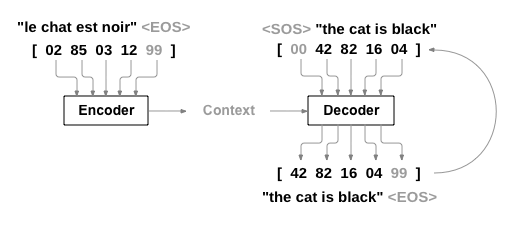

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'torch'

In [11]:
"""Print the versions of Python, PyTorch and NumPy."""
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.5.1+cu121
NumPy version: 1.26.3


In [2]:
torch.cuda.get_device_name

<function torch.cuda.get_device_name(device: Union[torch.device, str, int, NoneType] = None) -> str>

# Carregando arquivos de dados

Esta pergunta no Open Data Stack Exchange me indicou o site de tradução aberto [Tatoeba](https://tatoeba.org/), que possui downloads disponíveis em [https://tatoeba.org/eng/downloads](https://tatoeba.org/eng/downloads) — e, melhor ainda, alguém fez o trabalho extra de separar os pares de idiomas em arquivos de texto individuais neste site: [ManyThings](https://www.manythings.org/anki/)


In [3]:
!!unzip eng-fra.zip

['Archive:  eng-fra.zip',
 'replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

Semelhante à codificação de caracteres utilizada nos tutoriais de RNN a nível de caracteres, representaremos cada palavra em um idioma como um vetor one-hot, ou seja, um vetor gigante de zeros, exceto por um único 1 (na posição da palavra). Em comparação com as dezenas de caracteres que podem existir em um idioma, há muitas mais palavras, de modo que o vetor de codificação é muito maior. No entanto, faremos uma pequena concessão e limitaremos os dados para usar apenas alguns milhares de palavras por idioma.

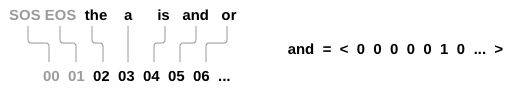

Precisaremos de um índice único para cada palavra para utilizar como entradas e alvos das redes posteriormente. Para acompanhar tudo isso, usaremos uma classe auxiliar chamada **Lang**, que possui dicionários para mapear palavra → índice (`word2index`) e índice → palavra (`index2word`), além de uma contagem de cada palavra (`word2count`), que será utilizada para substituir palavras raras posteriormente.

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Todos os arquivos estão em Unicode; para simplificar, converteremos os caracteres Unicode para ASCII, deixaremos tudo em minúsculas e removeremos a maior parte da pontuação.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Como há muitas sentenças de exemplo e queremos treinar algo rapidamente, vamos reduzir o conjunto de dados para incluir apenas sentenças relativamente curtas e simples. Aqui, o comprimento máximo é de 10 palavras (isso inclui a pontuação final) e estamos filtrando para sentenças que se traduzem para a forma “I am” ou “He is”, etc. (considerando os apóstrofos substituídos anteriormente).

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

O processo completo para preparar os dados é:

 * Leia o arquivo de texto e divida-o em linhas, divida as linhas em pares  
 * Normalize o texto, filtrando por comprimento e conteúdo  
 * Crie listas de palavras a partir das sentenças nos pares


In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['tu es tres en colere', 'you re very angry']


Uma Rede Neural Recorrente, ou RNN, é uma rede que opera sobre uma sequência e utiliza sua própria saída como entrada para etapas subsequentes.

Uma rede de Sequência para Sequência, ou rede seq2seq, ou rede Codificador-Decodificador, é um modelo composto por duas RNNs chamadas codificador e decodificador. O codificador lê uma sequência de entrada e gera um único vetor, e o decodificador lê esse vetor para produzir uma sequência de saída.

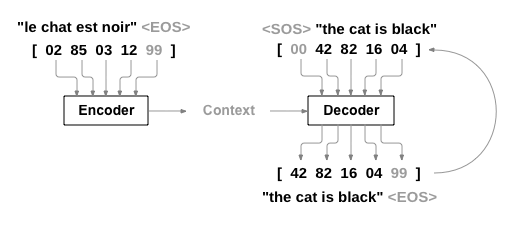

Diferentemente da previsão de sequência com uma única RNN, onde cada entrada corresponde a uma saída, o modelo seq2seq nos liberta das restrições de comprimento e ordem da sequência, o que o torna ideal para a tradução entre dois idiomas.

Considere a sentença *Je ne suis pas le chat noir* → *I am not the black cat*. A maioria das palavras na sentença de entrada possui uma tradução direta na sentença de saída, mas em ordens ligeiramente diferentes, por exemplo, *chat noir* e *black cat*. Devido à construção *ne/pas*, há também uma palavra a mais na sentença de entrada. Seria difícil produzir uma tradução correta diretamente a partir da sequência de palavras de entrada.

Com um modelo seq2seq, o codificador cria um único vetor que, no cenário ideal, codifica o “significado” da sequência de entrada em um único vetor — um único ponto em algum espaço N-dimensional de sentenças.

# O Codificador

O codificador de uma rede seq2seq é uma RNN que gera algum valor para cada palavra da sentença de entrada. Para cada palavra de entrada, o codificador gera um vetor e um estado oculto, e utiliza esse estado oculto para a próxima palavra de entrada.

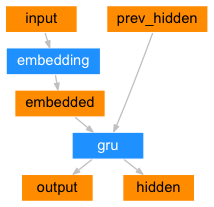

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

# O decodificador 

O decodificador é outra RNN que recebe o(s) vetor(es) de saída do codificador e gera uma sequência de palavras para criar a tradução.  
**Decodificador Simples**

No decodificador seq2seq mais simples, usamos apenas a última saída do codificador. Essa última saída é às vezes chamada de vetor de contexto, pois codifica o contexto de toda a sequência. Esse vetor de contexto é usado como o estado oculto inicial do decodificador.

A cada etapa da decodificação, o decodificador recebe um token de entrada e um estado oculto. O token de entrada inicial é o token de início de cadeia `<SOS>`, e o primeiro estado oculto é o vetor de contexto (o último estado oculto do codificador).

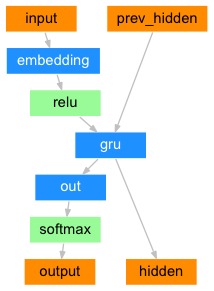

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

Incentivo você a treinar e observar os resultados deste modelo, mas, para economizar espaço, iremos direto ao ponto e introduzir o Mecanismo de Atenção.

# Decodificador com Atenção

Se apenas o vetor de contexto for passado entre o codificador e o decodificador, esse único vetor carregará a responsabilidade de codificar toda a sentença.

A atenção permite que a rede decodificadora "se concentre" em uma parte diferente das saídas do codificador a cada etapa de suas próprias saídas. Primeiro, calculamos um conjunto de pesos de atenção. Estes serão multiplicados pelos vetores de saída do codificador para criar uma combinação ponderada. O resultado (chamado `attn_applied` no código) deve conter informações sobre aquela parte específica da sequência de entrada e, assim, ajudar o decodificador a escolher as palavras de saída corretas.

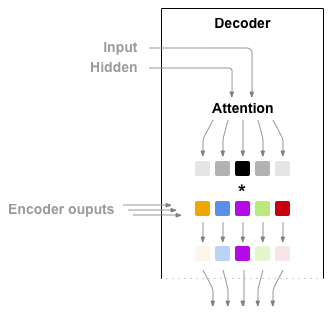

O cálculo dos pesos de atenção é realizado por meio de outra camada feed-forward, denominada `attn`, utilizando a entrada do decodificador e o estado oculto como insumos. Como o conjunto de treinamento contém sentenças de diversos comprimentos, para criar e treinar essa camada precisamos definir um comprimento máximo de sentença (comprimento de entrada, para as saídas do codificador) ao qual ela se aplicará. Sentenças com comprimento máximo utilizarão todos os pesos de atenção, enquanto sentenças mais curtas utilizarão apenas os iniciais.

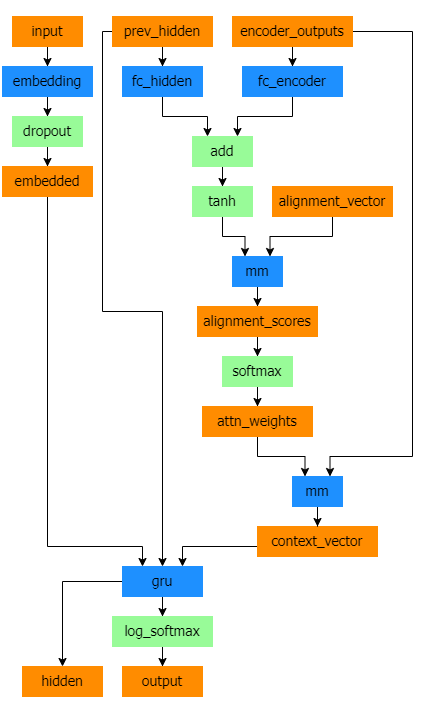

A atenção de Bahdanau, também conhecida como atenção aditiva, é um mecanismo de atenção comumente utilizado em modelos seq2seq, particularmente em tarefas de tradução automática neural. Ela foi introduzida por Bahdanau et al. em seu artigo intitulado *Neural Machine Translation by Jointly Learning to Align and Translate*. Esse mecanismo emprega um modelo de alinhamento aprendido para calcular pontuações de atenção entre os estados ocultos do codificador e do decodificador, utilizando uma rede neural feed-forward para essa finalidade.

No entanto, existem mecanismos alternativos, como a atenção de Luong, que calcula as pontuações de atenção realizando o produto escalar entre o estado oculto do decodificador e os estados ocultos do codificador, sem envolver a transformação não-linear utilizada na atenção de Bahdanau.

Neste tutorial, utilizaremos a atenção de Bahdanau. Contudo, seria um exercício interessante explorar a modificação do mecanismo de atenção para usar a atenção de Luong.

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Existem outras formas de atenção que contornam a limitação de comprimento utilizando uma abordagem baseada em posição relativa. Leia sobre "local attention" em *Effective Approaches to Attention-based Neural Machine Translation*.

# Treinamento

## Preparando os Dados de Treinamento

Para treinar, para cada par, precisaremos de um tensor de entrada (índices das palavras na sentença de entrada) e de um tensor alvo (índices das palavras na sentença alvo). Ao criar esses vetores, adicionaremos o token EOS a ambas as sequências.

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

## Treinando o Modelo

Para treinar, passamos a sentença de entrada pelo codificador, registrando cada saída e o último estado oculto. Em seguida, o decodificador recebe o token `<SOS>` como sua primeira entrada e o último estado oculto do codificador como seu primeiro estado oculto.

"Teacher forcing" é o conceito de usar as saídas-alvo reais como cada próxima entrada, em vez de usar a estimativa do decodificador como a entrada seguinte. Utilizar teacher forcing faz com que a convergência seja mais rápida, mas quando a rede treinada é utilizada, pode apresentar instabilidade.

Você pode observar que as saídas das redes com teacher forcing possuem uma gramática coerente, mas se desviam bastante da tradução correta — intuitivamente, a rede aprendeu a representar a gramática de saída e consegue "captar" o significado assim que o professor fornece as primeiras palavras, mas não aprendeu adequadamente como construir a sentença a partir da tradução originalmente.

Devido à liberdade proporcionada pelo autograd do PyTorch, podemos escolher aleatoriamente utilizar ou não o teacher forcing com uma simples instrução `if`. Aumente o parâmetro `teacher_forcing_ratio` para usá-lo com mais frequência.

In [13]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [14]:
# This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Todo o processo de treinamento se estrutura da seguinte forma:

* Inicie um temporizador  
* Inicialize os otimizadores e o critério  
* Crie um conjunto de pares de treinamento  
* Inicie um array vazio de perdas para plotagem

Em seguida, chamamos a função de treinamento várias vezes e, ocasionalmente, imprimimos o progresso (porcentagem de exemplos, tempo decorrido, tempo estimado) e a perda média.


In [15]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Plotando os Resultados

A plotagem é realizada com matplotlib, utilizando o array de valores de perda (`plot_losses`) salvo durante o treinamento.

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')

import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Avaliação

A avaliação é basicamente a mesma do treinamento, mas não há alvos, então simplesmente alimentamos as previsões do decodificador de volta para ele mesmo a cada etapa. Sempre que ele prevê uma palavra, a adicionamos à string de saída e, se ele prever o token EOS, interrompemos o processo. Também armazenamos as saídas de atenção do decodificador para exibição posterior.

In [19]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

Podemos avaliar sentenças aleatórias do conjunto de treinamento e imprimir a entrada, o alvo e a saída para realizar alguns julgamentos subjetivos de qualidade:

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Treinamento e Avaliação

Com todas essas funções auxiliares implementadas (parece trabalho extra, mas facilita a execução de múltiplos experimentos), podemos, na verdade, inicializar uma rede e começar o treinamento.

Lembre-se de que as sentenças de entrada foram fortemente filtradas. Para este pequeno conjunto de dados, podemos utilizar redes relativamente pequenas, com 256 nós ocultos e uma única camada GRU. 

Observação: Se você executar este notebook, poderá treinar, interromper o kernel, avaliar e continuar o treinamento mais tarde. Comente as linhas onde o codificador e o decodificador são inicializados e execute `trainIters` novamente.


In [ ]:
hidden_size = 256
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 32s (- 8m 0s) (5 6%) 1.5401
1m 2s (- 7m 14s) (10 12%) 0.6912
1m 30s (- 6m 33s) (15 18%) 0.3629
1m 59s (- 5m 57s) (20 25%) 0.2014
2m 26s (- 5m 23s) (25 31%) 0.1236
2m 55s (- 4m 52s) (30 37%) 0.0854
3m 23s (- 4m 22s) (35 43%) 0.0647
3m 52s (- 3m 52s) (40 50%) 0.0532
4m 20s (- 3m 22s) (45 56%) 0.0452
4m 49s (- 2m 53s) (50 62%) 0.0407
5m 17s (- 2m 24s) (55 68%) 0.0376
5m 46s (- 1m 55s) (60 75%) 0.0349
6m 14s (- 1m 26s) (65 81%) 0.0328
6m 43s (- 0m 57s) (70 87%) 0.0314
7m 10s (- 0m 28s) (75 93%) 0.0306
7m 37s (- 0m 0s) (80 100%) 0.0294


## Visualizando a Atenção

Uma propriedade útil do mecanismo de atenção é que suas saídas são altamente interpretáveis. Como ele é usado para ponderar saídas específicas do codificador na sequência de entrada, podemos imaginar onde a rede está mais focada em cada etapa.

Você pode simplesmente executar `plt.matshow(attentions)` para ver a saída de atenção exibida como uma matriz. Para uma experiência visual melhor, faremos um trabalho extra adicionando eixos e rótulos:

In [27]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


In [26]:
evaluateAndShowAttention('il n est pas aussi grand que son pere')

# evaluateAndShowAttention('je suis trop fatigue pour conduire')

# evaluateAndShowAttention('je suis desole si c est une question idiote')

# evaluateAndShowAttention('je suis reellement fiere de vous')

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_103813/1207448039.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Exercícios

* Experimente com um conjunto de dados diferente  
  * Outro par de idiomas  
  * Humano → Máquina (por exemplo, comandos de IOT)  
  * Chat → Resposta  
  * Pergunta → Resposta

* Substitua as embeddings por embeddings de palavras pré-treinadas, como word2vec ou GloVe

* Experimente com mais camadas, mais unidades ocultas e mais sentenças. Compare o tempo de treinamento e os resultados.

* Se você usar um arquivo de tradução onde os pares contêm duas vezes a mesma frase (I am test	 I am test), pode utilizá-lo como um autoencoder. Experimente isto:
  * Treine como um autoencoder  
  * Salve apenas a rede codificadora (Encoder)  
  * Treine um novo decodificador (Decoder) para tradução a partir daí
